In [23]:
import pandas as pd
from pygam import LogisticGAM, s, te, f, l
from pygam import LinearGAM, s, f, te
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn import tree
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import partial_dependence
from sklearn.preprocessing import LabelEncoder
from pdpbox import pdp, info_plots
import os
import sys

# Define the current working directory
cwd = os.getcwd()

# load the data
data = pd.read_csv(cwd + '/health_data.csv')
data

,Unnamed: 0,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,0.0,18393.0,1,168.0,62.0,110.0,80.0,0,0,0,0,1,0
1,1,1.0,20228.0,0,156.0,85.0,140.0,90.0,2,0,0,0,1,1
2,2,2.0,18857.0,0,165.0,64.0,130.0,70.0,2,0,0,0,0,1
3,3,3.0,17623.0,1,169.0,82.0,150.0,100.0,0,0,0,0,1,1
4,4,4.0,17474.0,0,156.0,56.0,100.0,60.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,69995,99993.0,19240.0,1,168.0,76.0,120.0,80.0,0,0,1,0,1,0
69996,69996,99995.0,22601.0,0,158.0,126.0,140.0,90.0,1,1,0,0,1,1
69997,69997,99996.0,19066.0,1,183.0,105.0,180.0,90.0,2,0,0,1,0,1
69998,69998,99998.0,22431.0,0,163.0,72.0,135.0,80.0,0,1,0,0,0,1


In [24]:
# Create a working copy to avoid modifying the original data
df = data.copy()

# Define th list of categoriacl variables
categorical = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']

# Convert inf to NaN, although according to the data description there are no Infs
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Remove NaNs, although according to the data description there are no NaNs
df.dropna(inplace=True)

# Drop the id column and -1
df.drop(['id', 'Unnamed: 0'], axis=1, inplace=True)

# Convert age in days
df['age'] = df['age']/365.25

# Filter for impossible values for height, weight, ap_hi, ap_lo
df = df[(df['height'] > 130) & (df['height'] < 220)]
df = df[(df['weight'] > 30) & (df['weight'] < 200)]
df = df[(df['ap_hi'] > 60) & (df['ap_hi'] < 240)]
df = df[(df['ap_lo'] > 40) & (df['ap_lo'] < 200)]
df = df[df['age'] <100]

# Add a new column for the BMI
df['BMI'] = df['weight'] / (df['height'] / 100) ** 2

# Filter for reasonable values for BMI
df = df[(df['BMI'] > 6) & (df['BMI'] < 70)]

# Convert all categorical variables to strings,
# this will be undone at a later stage (remember to do it before the model)
df[categorical] = df[categorical].astype(str)

# Reset index for... resons?
df.reset_index(drop=True, inplace=True)

# Put the cardio column at the end
df = df[[c for c in df if c not in ['cardio']] + ['cardio']]

# Here's the resulting df
df

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,BMI,cardio
0,50.357290,1,168.0,62.0,110.0,80.0,0,0,0,0,1,21.967120,0
1,55.381246,0,156.0,85.0,140.0,90.0,2,0,0,0,1,34.927679,1
2,51.627652,0,165.0,64.0,130.0,70.0,2,0,0,0,0,23.507805,1
3,48.249144,1,169.0,82.0,150.0,100.0,0,0,0,0,1,28.710479,1
4,47.841205,0,156.0,56.0,100.0,60.0,0,0,0,0,0,23.011177,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68636,52.676249,1,168.0,76.0,120.0,80.0,0,0,1,0,1,26.927438,0
68637,61.878166,0,158.0,126.0,140.0,90.0,1,1,0,0,1,50.472681,1
68638,52.199863,1,183.0,105.0,180.0,90.0,2,0,0,1,0,31.353579,1
68639,61.412731,0,163.0,72.0,135.0,80.0,0,1,0,0,0,27.099251,1


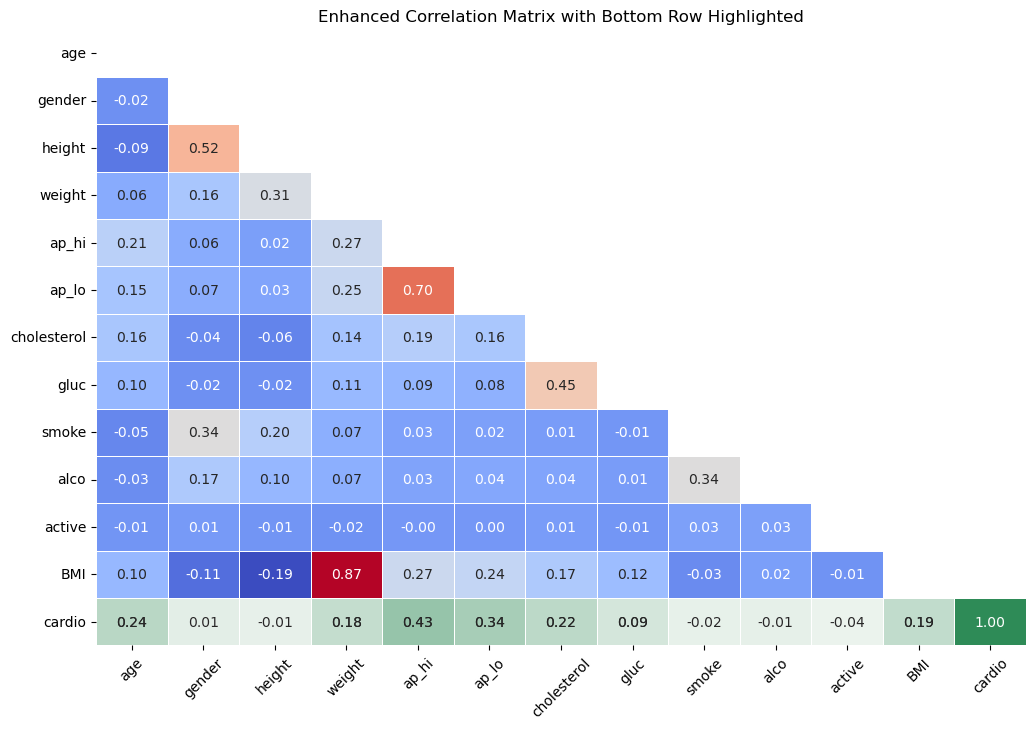

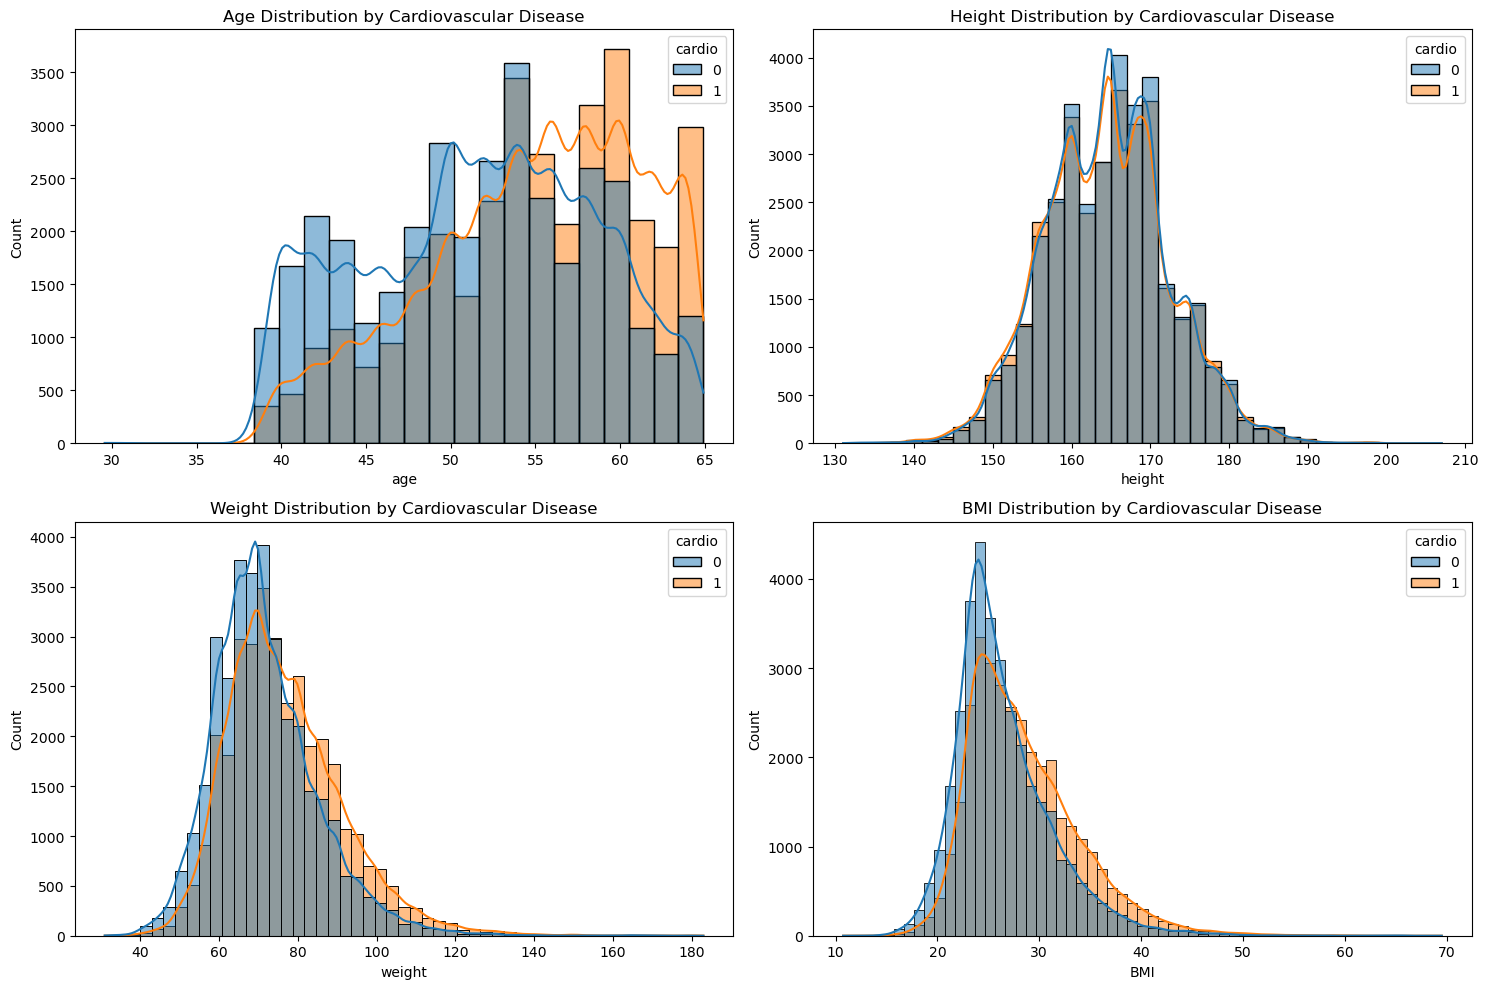

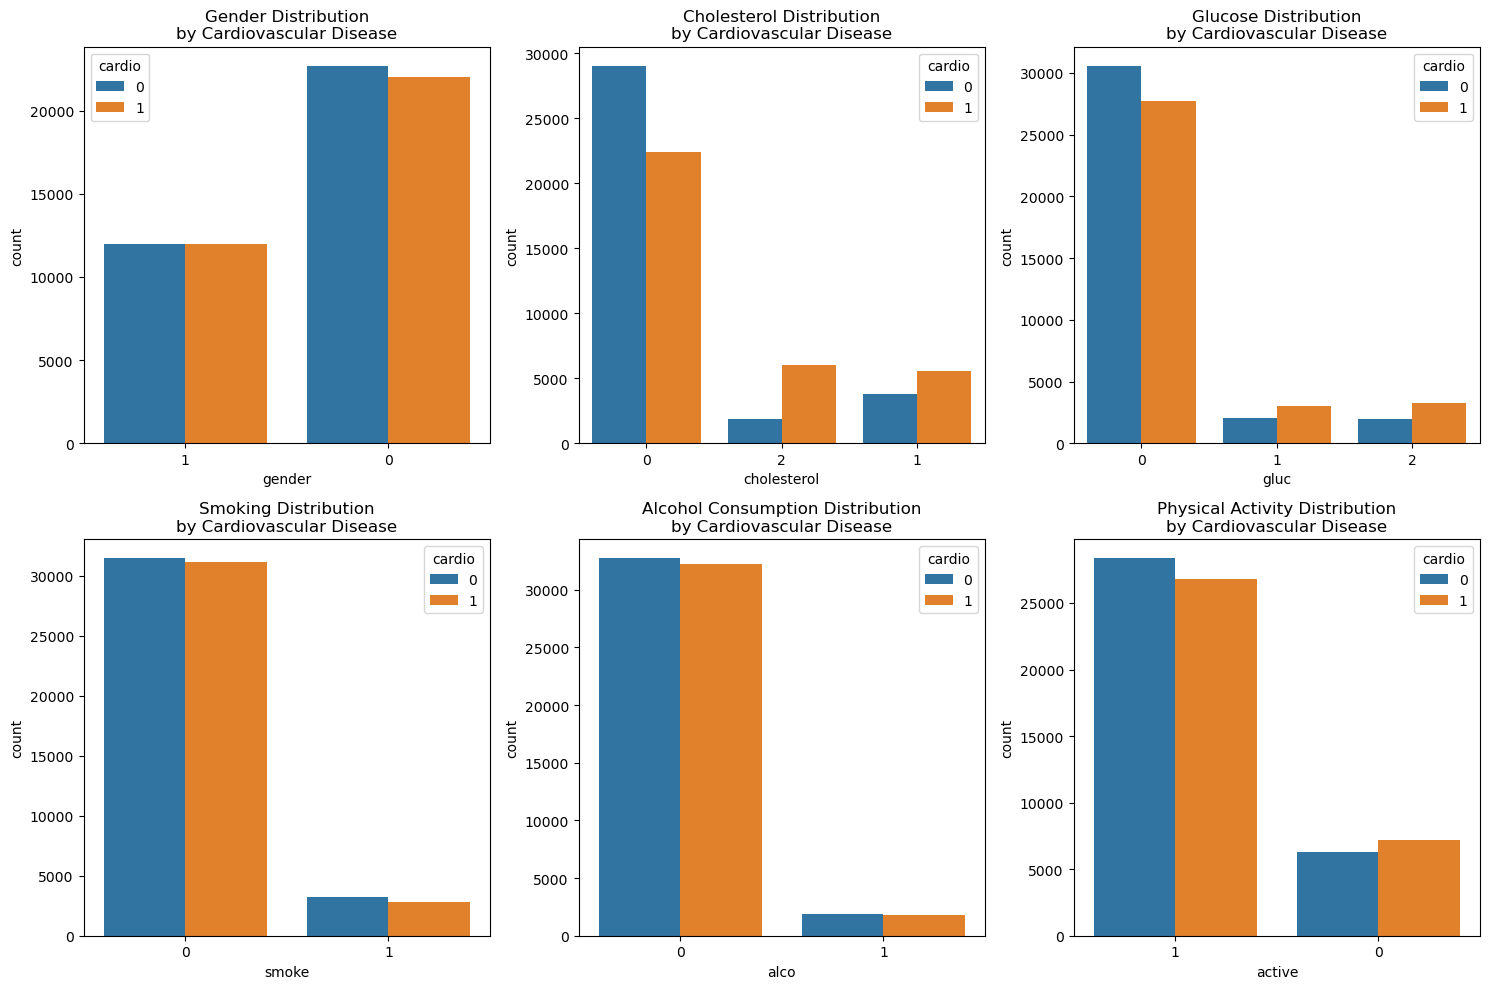

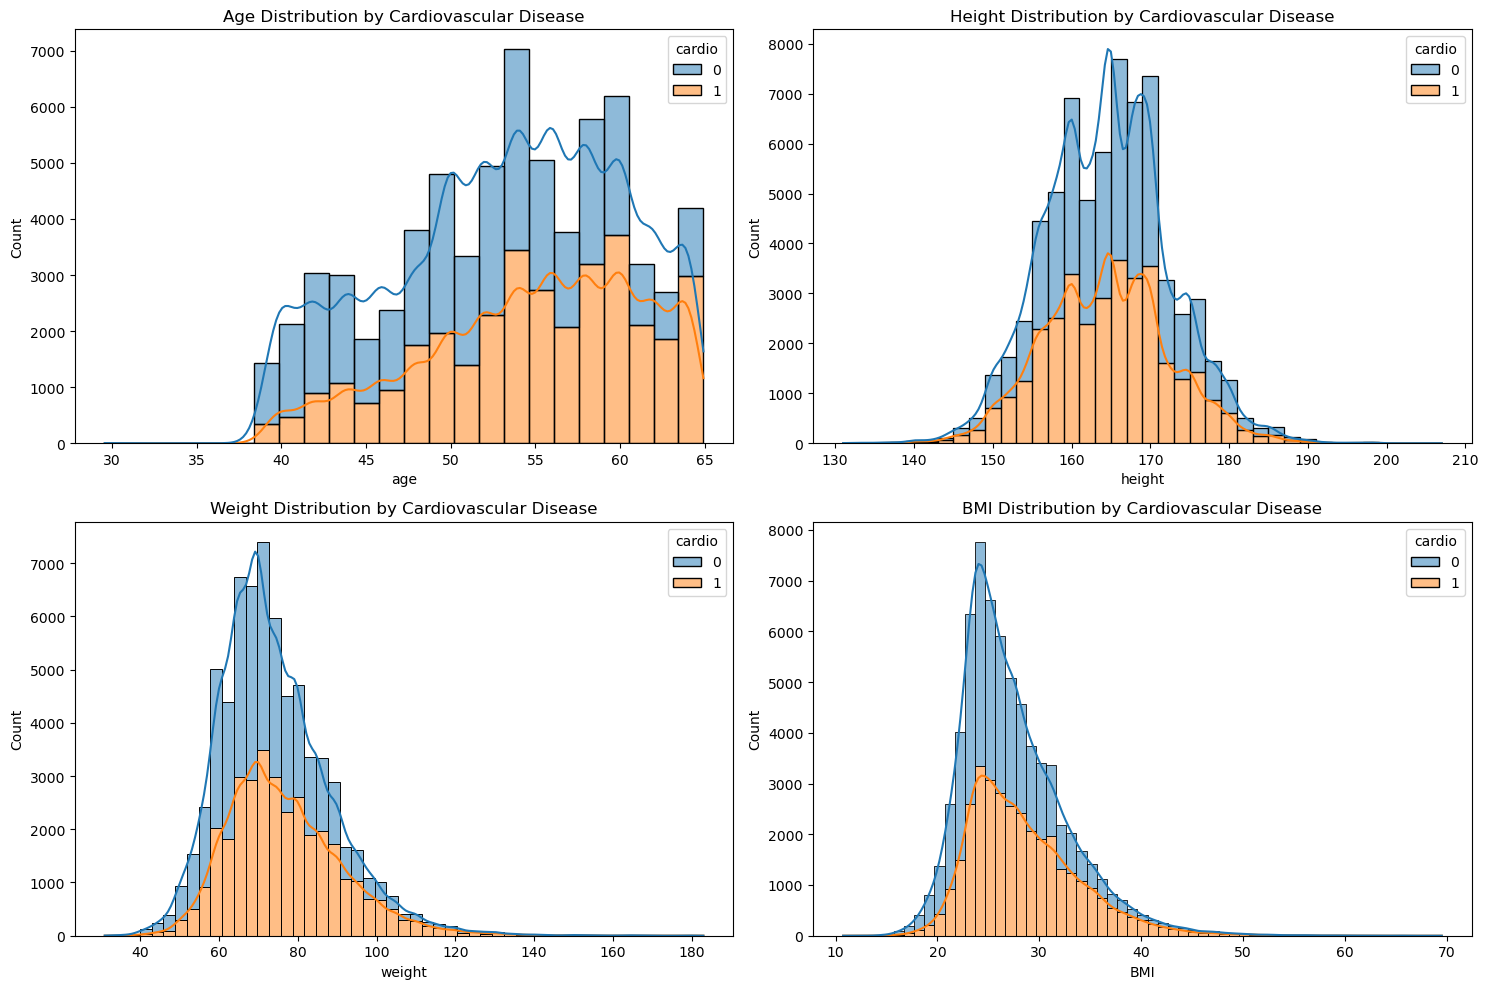

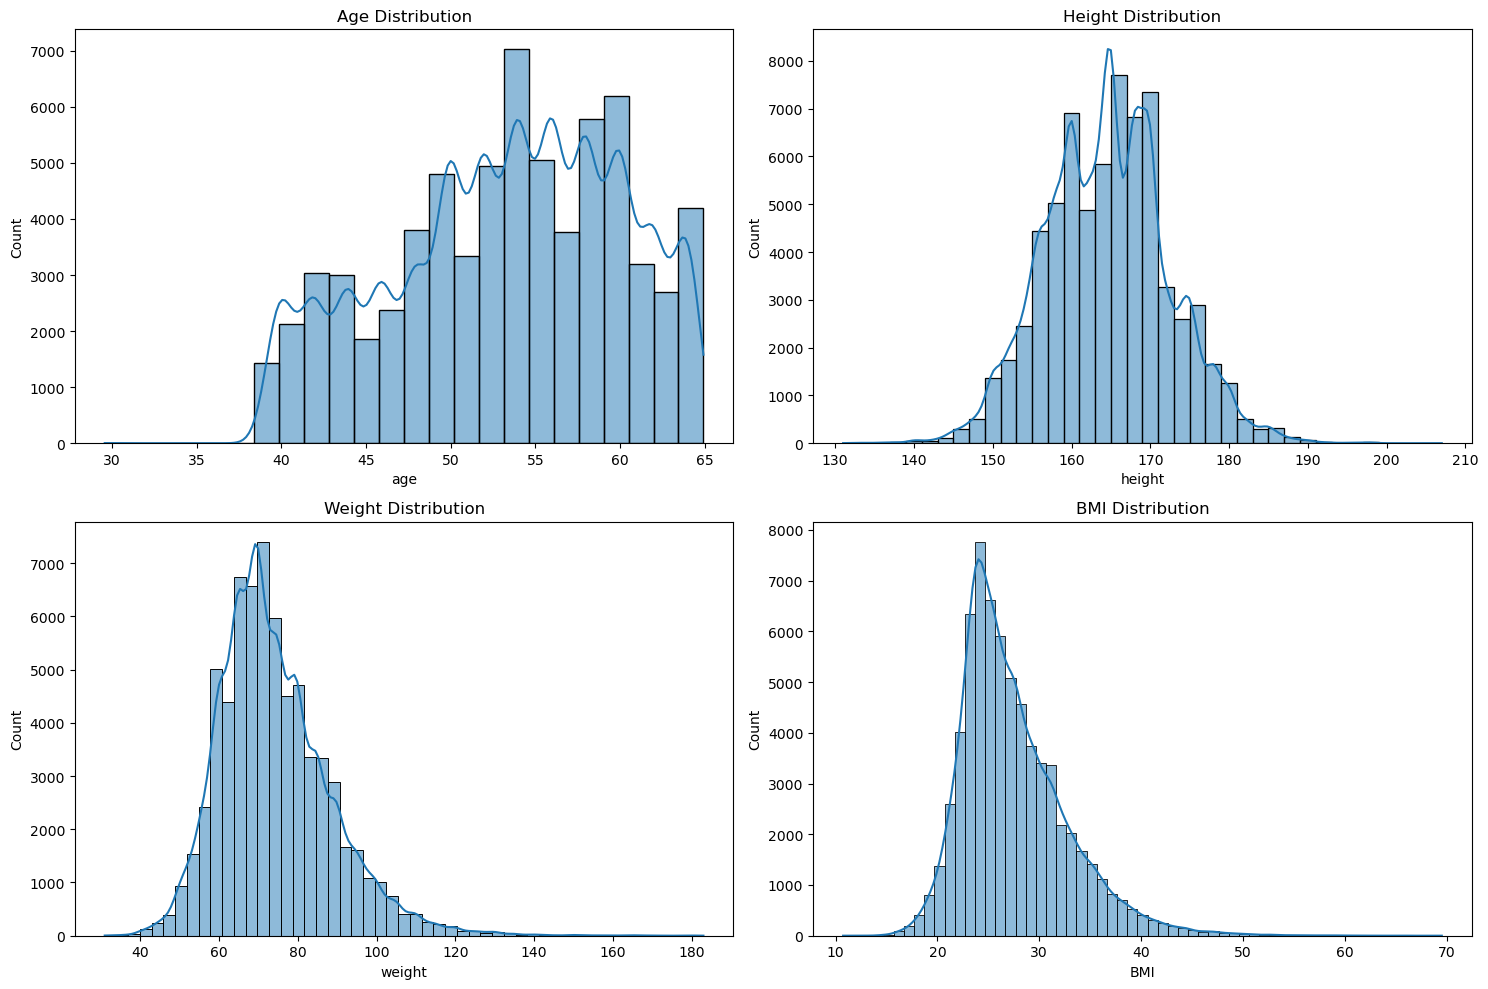

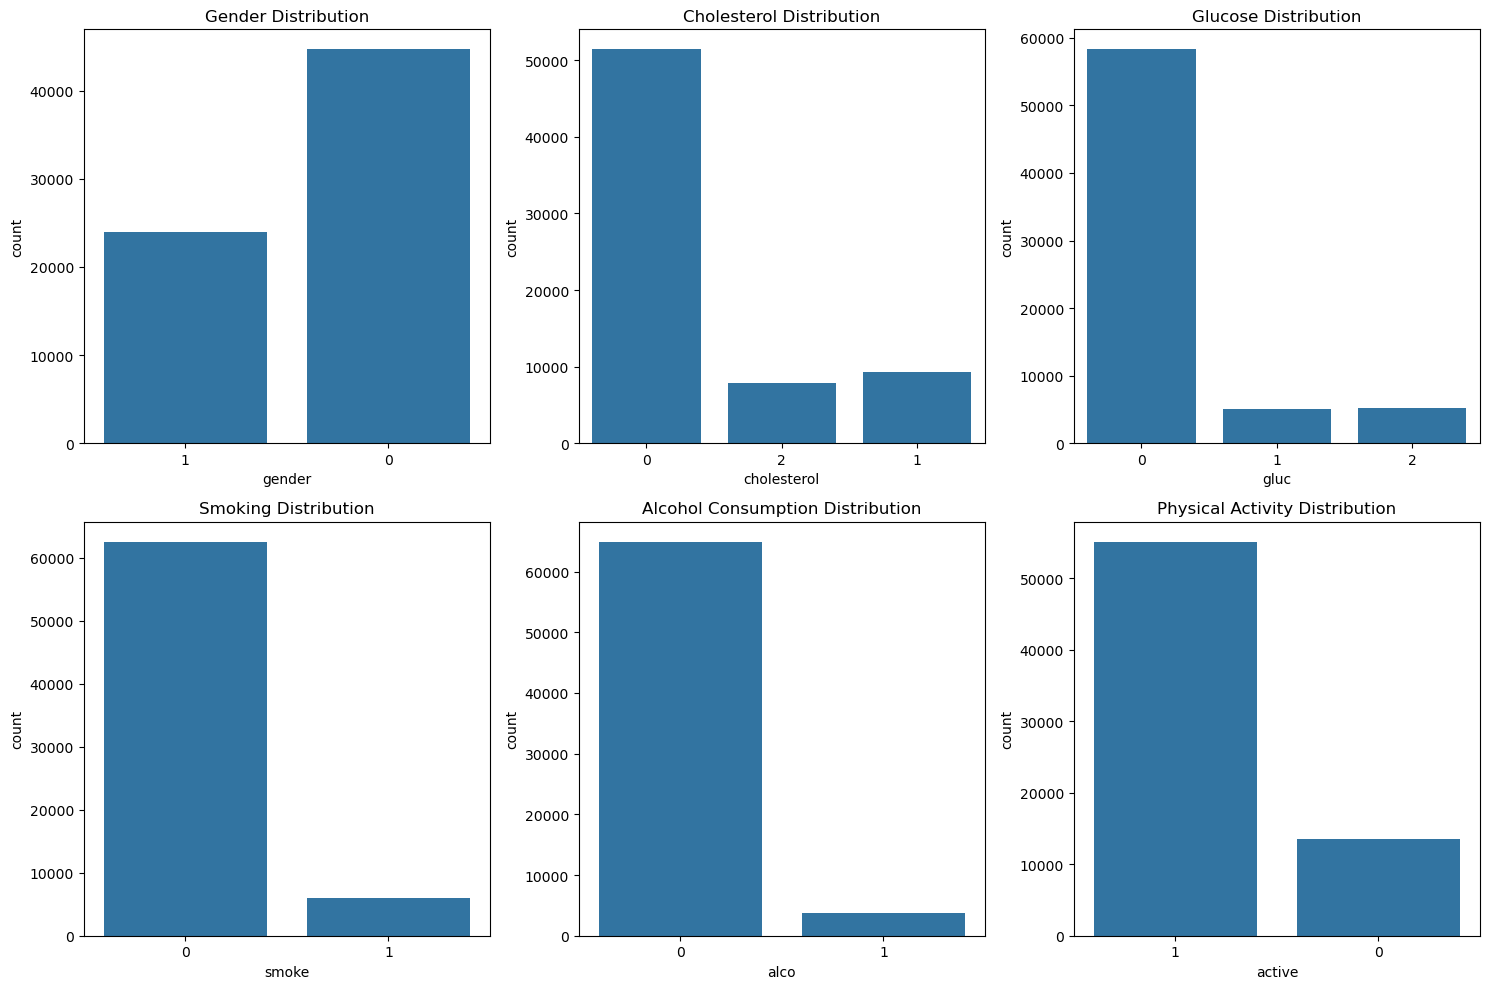

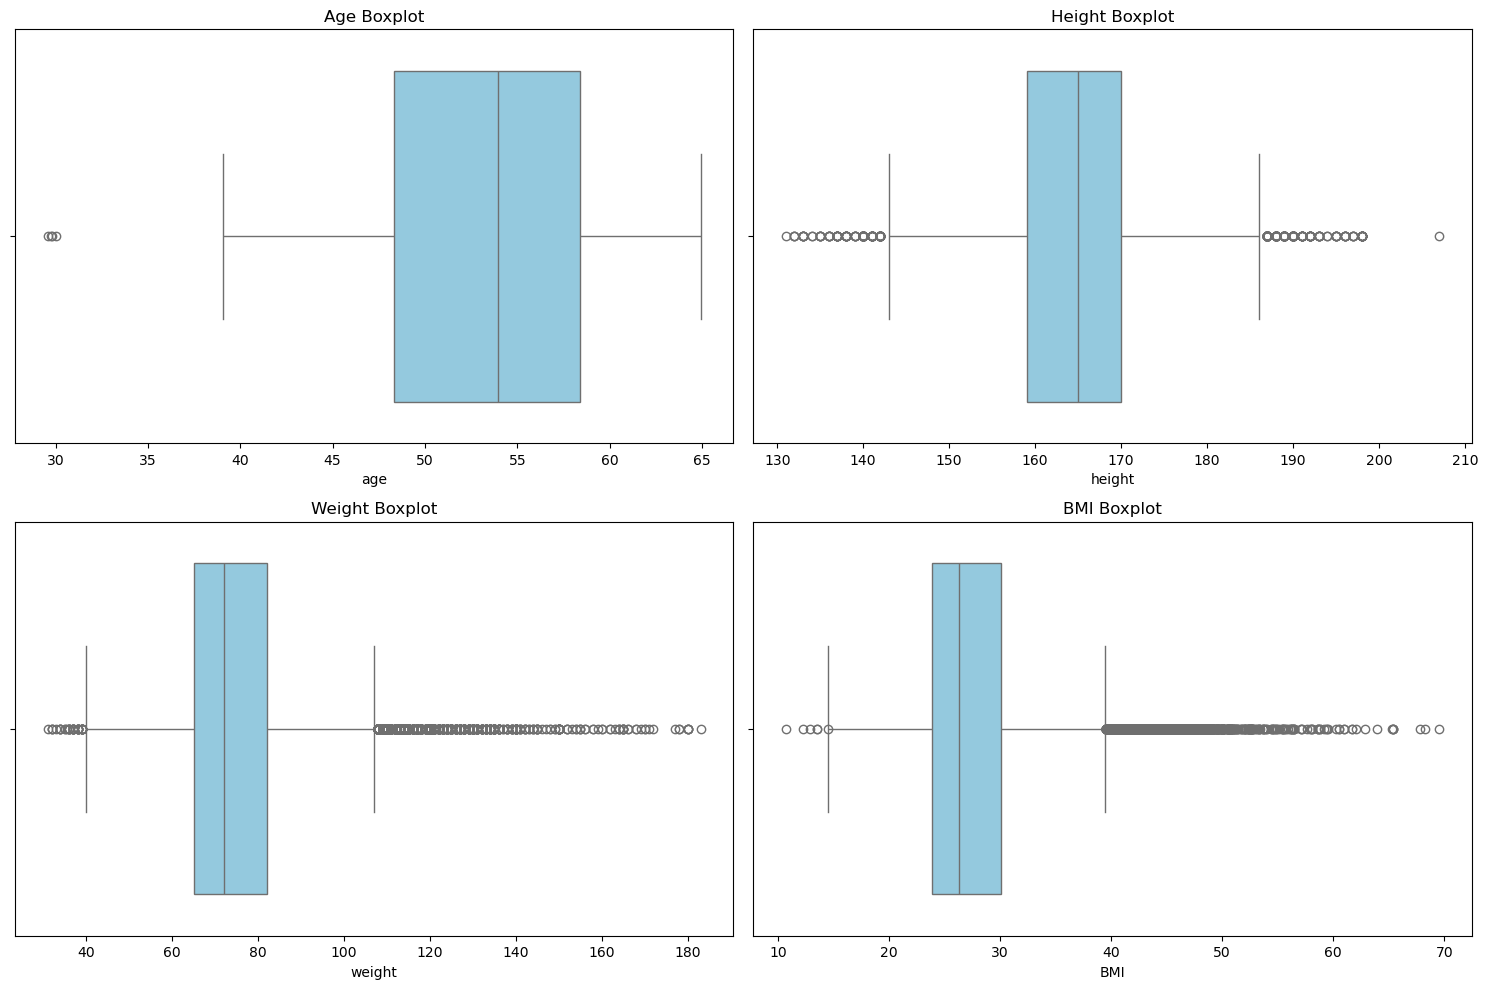

In [25]:
# Create a copy of the cleaned dataset to use for EDA
df_eda = df.copy()

####################################################
## CORRELATION MATRIX WITH HIGHLIGHTED BOTTOM ROW ##
####################################################

plt.figure(figsize=(12, 8))
# Creating a mask for the upper triangle
mask_upper = np.triu(np.ones_like(df.corr(), dtype=bool))
# Creating a mask for all but the bottom row (for highlighting)
mask_not_bottom = np.ones_like(df.corr(), dtype=bool)
mask_not_bottom[-1, :] = False  # Unmask the bottom row
# Plot the main heatmap with the upper triangle masked
sns.heatmap(df.corr(), annot=True, mask=mask_upper, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar=False)
# Overlay with the bottom row highlighted
# Adjust 'highlight_cmap' to change the highlight color
highlight_cmap = sns.light_palette("seagreen", as_cmap=True)
sns.heatmap(df.corr(), annot=True, mask=mask_not_bottom, cmap=highlight_cmap, fmt=".2f", linewidths=.5, cbar=False)
plt.xticks(rotation=45)
plt.title('Enhanced Correlation Matrix with Bottom Row Highlighted')
plt.show()

#################
## OTHER PLOTS ##
#################

# Plot the distribution of the target variable according to the numerical variables
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.histplot(df_eda, x='age', hue='cardio', kde=True, binwidth=1.5, ax=ax[0, 0])
ax[0, 0].set_title('Age Distribution by Cardiovascular Disease')
sns.histplot(df_eda, x='height', hue='cardio', kde=True, binwidth=2, ax=ax[0, 1])
ax[0, 1].set_title('Height Distribution by Cardiovascular Disease')
sns.histplot(df_eda, x='weight', hue='cardio', kde=True, binwidth=3, ax=ax[1, 0])
ax[1, 0].set_title('Weight Distribution by Cardiovascular Disease')
sns.histplot(df_eda, x='BMI', hue='cardio', kde=True, binwidth=1, ax=ax[1, 1])
ax[1, 1].set_title('BMI Distribution by Cardiovascular Disease')
plt.tight_layout()
plt.show()

# Plotting the distribution of the target variable according to the categorical variables
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
sns.countplot(x='gender', hue='cardio', data=df_eda,ax=ax[0, 0])
ax[0, 0].set_title('Gender Distribution\nby Cardiovascular Disease')
sns.countplot(x='cholesterol', hue='cardio', data=df_eda, ax=ax[0, 1])
ax[0, 1].set_title('Cholesterol Distribution\nby Cardiovascular Disease')
sns.countplot(x='gluc', hue='cardio', data=df_eda, ax=ax[0, 2])
ax[0, 2].set_title('Glucose Distribution\nby Cardiovascular Disease')
sns.countplot(x='smoke', hue='cardio', data=df_eda, ax=ax[1, 0])
ax[1, 0].set_title('Smoking Distribution\nby Cardiovascular Disease')
sns.countplot(x='alco', hue='cardio', data=df_eda, ax=ax[1, 1])
ax[1, 1].set_title('Alcohol Consumption Distribution\nby Cardiovascular Disease')
sns.countplot(x='active', hue='cardio', data=df_eda, ax=ax[1, 2])
ax[1, 2].set_title('Physical Activity Distribution\nby Cardiovascular Disease')
plt.tight_layout()
plt.show()

# Plot the numerical distribution like a population pyramid
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.histplot(df_eda, x='age', hue='cardio', kde=True, binwidth=1.5, ax=ax[0, 0], multiple='stack')
ax[0, 0].set_title('Age Distribution by Cardiovascular Disease')
sns.histplot(df_eda, x='height', hue='cardio', kde=True, binwidth=2, ax=ax[0, 1], multiple='stack')
ax[0, 1].set_title('Height Distribution by Cardiovascular Disease')
sns.histplot(df_eda, x='weight', hue='cardio', kde=True, binwidth=3, ax=ax[1, 0], multiple='stack')
ax[1, 0].set_title('Weight Distribution by Cardiovascular Disease')
sns.histplot(df_eda, x='BMI', hue='cardio', kde=True, binwidth=1, ax=ax[1, 1], multiple='stack')
ax[1, 1].set_title('BMI Distribution by Cardiovascular Disease')
plt.tight_layout()
plt.show()

#Variables values distributions
#numerical variables
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.histplot(df_eda, x='age', kde=True, binwidth=1.5, ax=ax[0, 0])
ax[0, 0].set_title('Age Distribution')
sns.histplot(df_eda, x='height', kde=True, binwidth=2, ax=ax[0, 1])
ax[0, 1].set_title('Height Distribution')
sns.histplot(df_eda, x='weight', kde=True, binwidth=3, ax=ax[1, 0])
ax[1, 0].set_title('Weight Distribution')
sns.histplot(df_eda, x='BMI', kde=True, binwidth=1, ax=ax[1, 1])
ax[1, 1].set_title('BMI Distribution')
plt.tight_layout()
plt.show()
#categorical variables
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
sns.countplot(x='gender', data=df_eda,ax=ax[0, 0])
ax[0, 0].set_title('Gender Distribution')
sns.countplot(x='cholesterol', data=df_eda, ax=ax[0, 1])
ax[0, 1].set_title('Cholesterol Distribution')
sns.countplot(x='gluc', data=df_eda, ax=ax[0, 2])
ax[0, 2].set_title('Glucose Distribution')
sns.countplot(x='smoke', data=df_eda, ax=ax[1, 0])
ax[1, 0].set_title('Smoking Distribution')
sns.countplot(x='alco', data=df_eda, ax=ax[1, 1])
ax[1, 1].set_title('Alcohol Consumption Distribution')
sns.countplot(x='active', data=df_eda, ax=ax[1, 2])
ax[1, 2].set_title('Physical Activity Distribution')
plt.tight_layout()
plt.show()

#Boxplots for numerical variables
# Variables values distributions - Numerical variables (including boxplots)
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
# Boxplots for numerical variables
sns.boxplot(x='age', data=df_eda, ax=ax[0, 0], color='skyblue')
ax[0, 0].set_title('Age Boxplot')
sns.boxplot(x='height', data=df_eda, ax=ax[0, 1], color='skyblue')
ax[0, 1].set_title('Height Boxplot')
sns.boxplot(x='weight', data=df_eda, ax=ax[1, 0], color='skyblue')
ax[1, 0].set_title('Weight Boxplot')
sns.boxplot(x='BMI', data=df_eda, ax=ax[1, 1], color='skyblue')
ax[1, 1].set_title('BMI Boxplot')
plt.tight_layout()
plt.show()

##da togliere api_lo, glucose, alco, height

In [26]:
import pandas as pd
import statsmodels.api as sm

# Assuming 'df' is your DataFrame and 'categorical' is a list of categorical variables

# Create a copy of the cleaned dataset to use for logistic regression
df_regression = df.copy()

# Convert all categorical variables to integers
df_regression[categorical] = df_regression[categorical].astype(int)

# Get the dummies
df_with_dummies = pd.get_dummies(df_regression, drop_first=True)

# For logistic regression, statsmodels requires us to add a constant to our model
df_with_dummies['intercept'] = 1.0

# Fit the logistic regression model
model = sm.Logit(df_with_dummies['cardio'], df_with_dummies.drop(columns=['cardio'])).fit()

# Display the model's summary
print(model.summary())

# Drop certain features and fit the model again
df_dropped_stuff = df.copy()
df_dropped_stuff[categorical] = df_dropped_stuff[categorical].astype(int)
df_dropped_stuff = df_dropped_stuff.drop(['gluc', 'alco', 'height', 'ap_lo'], axis=1).copy()
df_dummies = pd.get_dummies(df_dropped_stuff, drop_first=True)
df_dummies['intercept'] = 1.0
model_dropped = sm.Logit(df_dummies['cardio'], df_dummies.drop(columns=['cardio'])).fit()
print(model_dropped.summary())

# Drop 'gender' and fit the model again
df_dropped_stuff_nogend = df.copy()
df_dropped_stuff_nogend[categorical] = df_dropped_stuff_nogend[categorical].astype(int)
df_dropped_stuff_nogend = df_dropped_stuff_nogend.drop(['gluc', 'alco', 'height', 'ap_lo', 'gender'], axis=1).copy()
df_dummies_nogend = pd.get_dummies(df_dropped_stuff_nogend, drop_first=True)
df_dummies_nogend['intercept'] = 1.0
model_dropped_nd = sm.Logit(df_dummies_nogend['cardio'], df_dummies_nogend.drop(columns=['cardio'])).fit()
print(model_dropped_nd.summary())


# Perform the likelihood ratio test
lr_test = model.llf - model_dropped_nd.llf

# Degrees of freedom of the difference in the number of parameters between the two models
dof = len(model.params) - len(model_dropped_nd.params)

# p-value
from scipy.stats import chi2
p_value = chi2.sf(lr_test, dof)

print('Likelihood ratio test statistic between the full and cut model:', lr_test)
print('Degrees of freedom:', dof)
print('p-value:', p_value)

# Fit the null model
null_model = sm.Logit(df_with_dummies['cardio'], df_with_dummies['intercept']).fit()
print(null_model.summary())

# Perform the likelihood ratio test
lr_test_null = model_dropped_nd.llf - null_model.llf

# Degrees of freedom of the difference in the number of parameters between the two models
dof_null = len(model_dropped_nd.params) - len(null_model.params)

# p-value
p_value_null = chi2.sf(lr_test_null, dof_null)

print('Likelihood ratio test statistic between the cut and null model:', lr_test_null)
print('Degrees of freedom:', dof_null)
print('p-value:', p_value_null)


Optimization terminated successfully.
         Current function value: 0.560952
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 cardio   No. Observations:                68641
Model:                          Logit   Df Residuals:                    68628
Method:                           MLE   Df Model:                           12
Date:                Sun, 25 Feb 2024   Pseudo R-squ.:                  0.1907
Time:                        21:37:26   Log-Likelihood:                -38504.
converged:                       True   LL-Null:                       -47575.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
age             0.0516      0.001     38.033      0.000       0.049       0.054
gender         -0.0149    

AUC Score: 0.7965088250696274
Accuracy: 0.7303215279497677
LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     70.2264
Link Function:                        LogitLink Log Likelihood:                                -37787.9232
Number of Samples:                        68641 AIC:                                            75716.2992
                                                AICc:                                           75716.4492
                                                UBRE:                                               3.1039
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                    

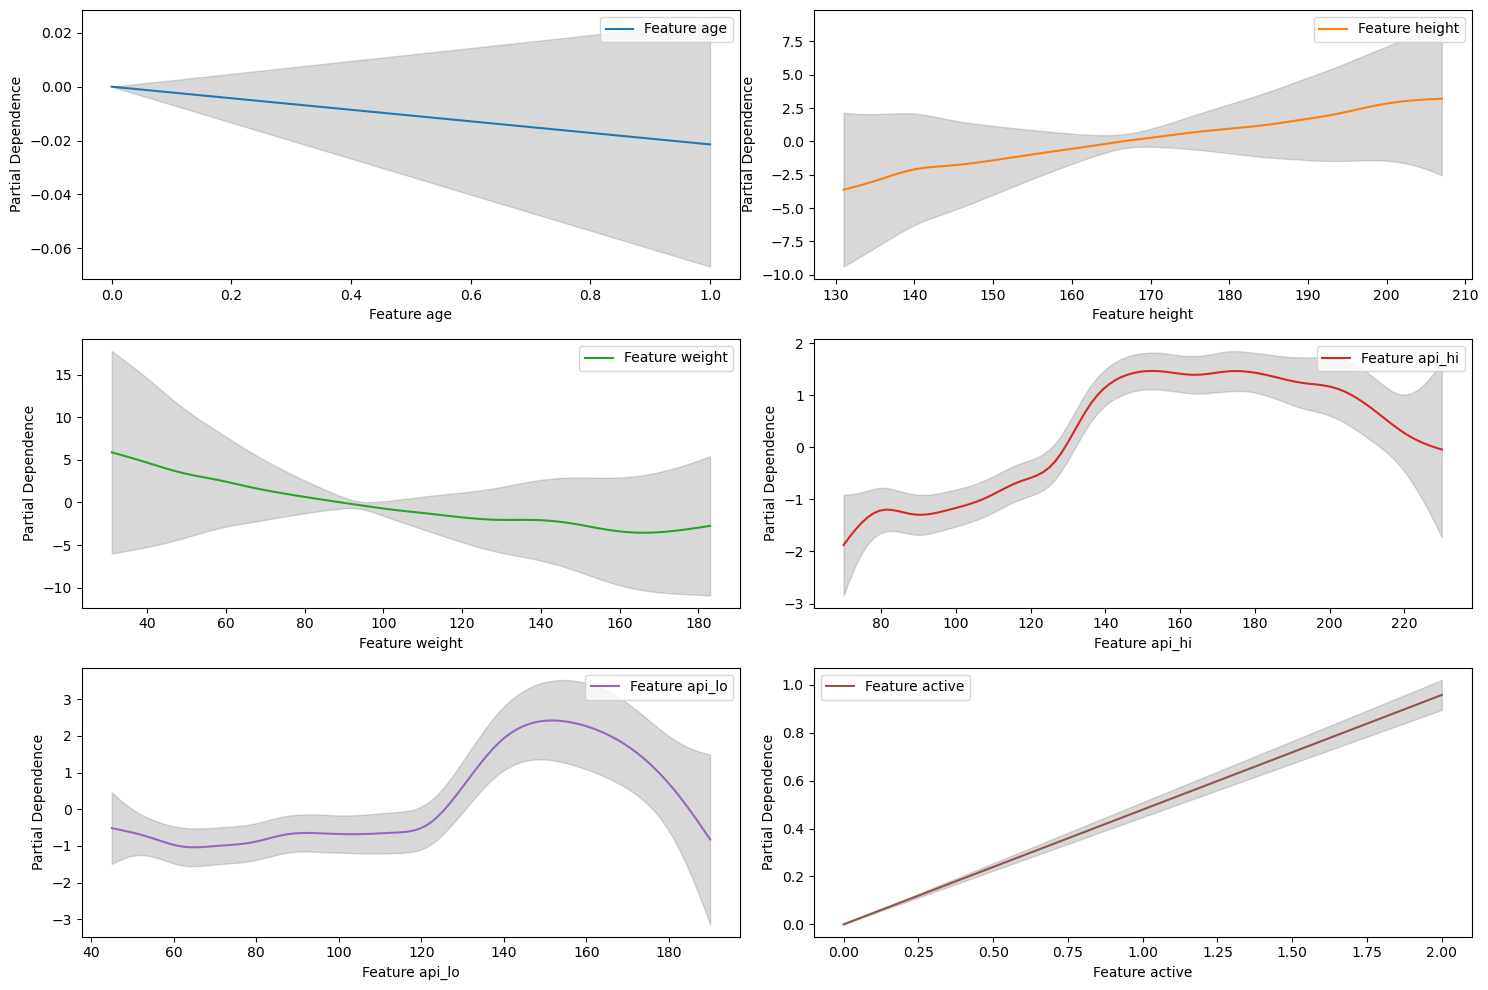

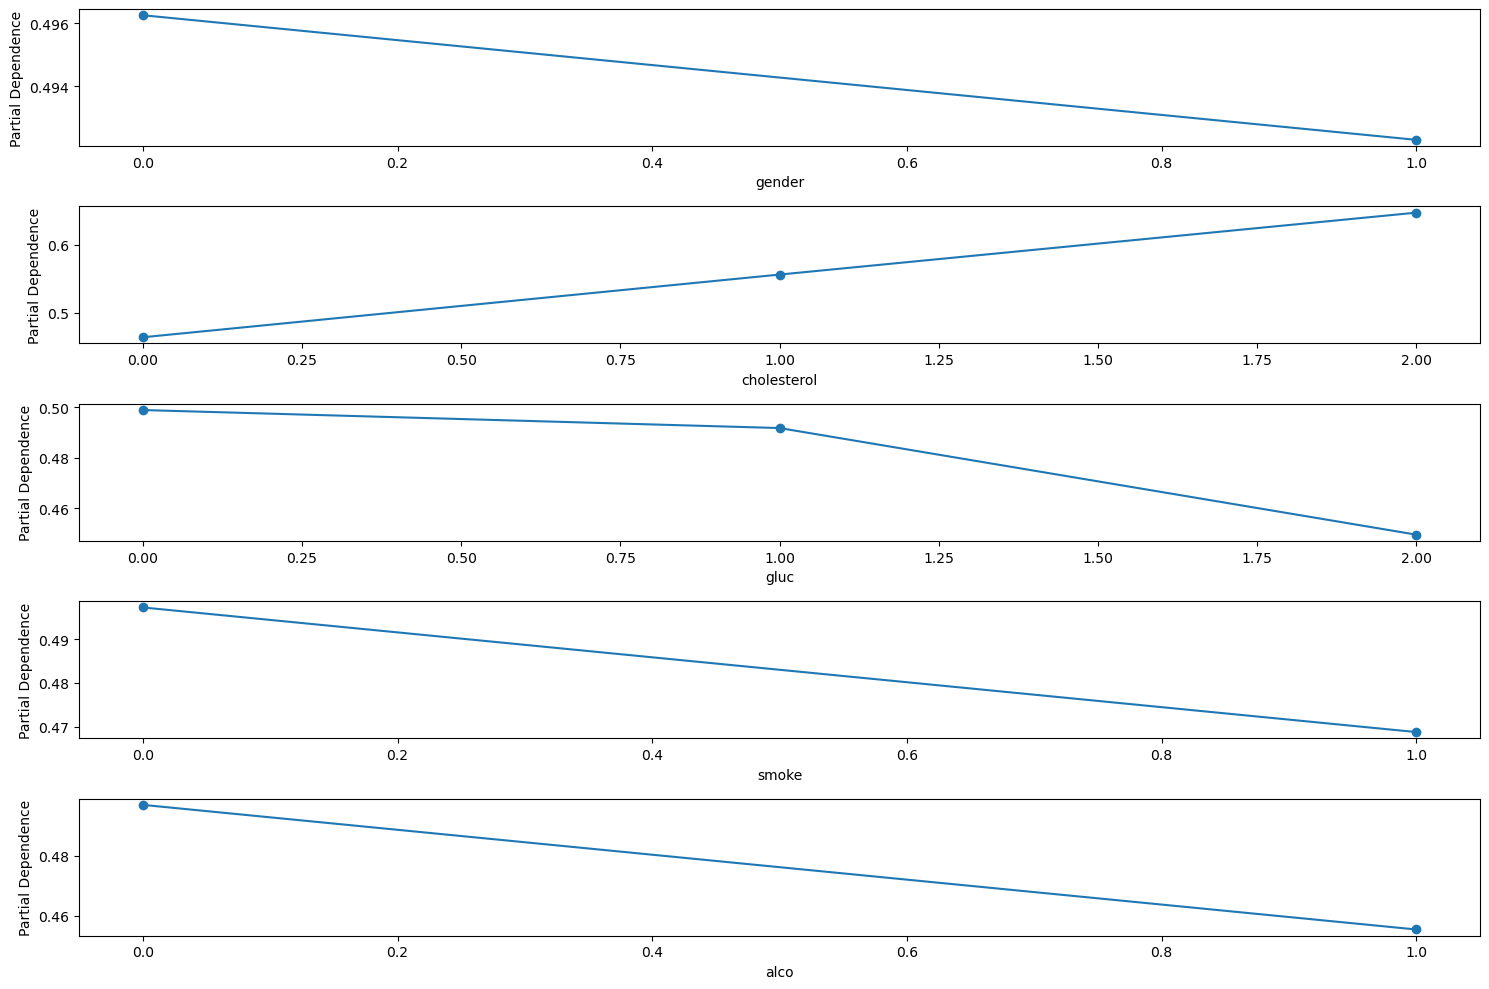

AUC Score: 0.7950610182545411
Accuracy: 0.727903148264157
LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      44.217
Link Function:                        LogitLink Log Likelihood:                                -37911.0885
Number of Samples:                        68641 AIC:                                            75910.6111
                                                AICc:                                            75910.672
                                                UBRE:                                               3.1064
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                     

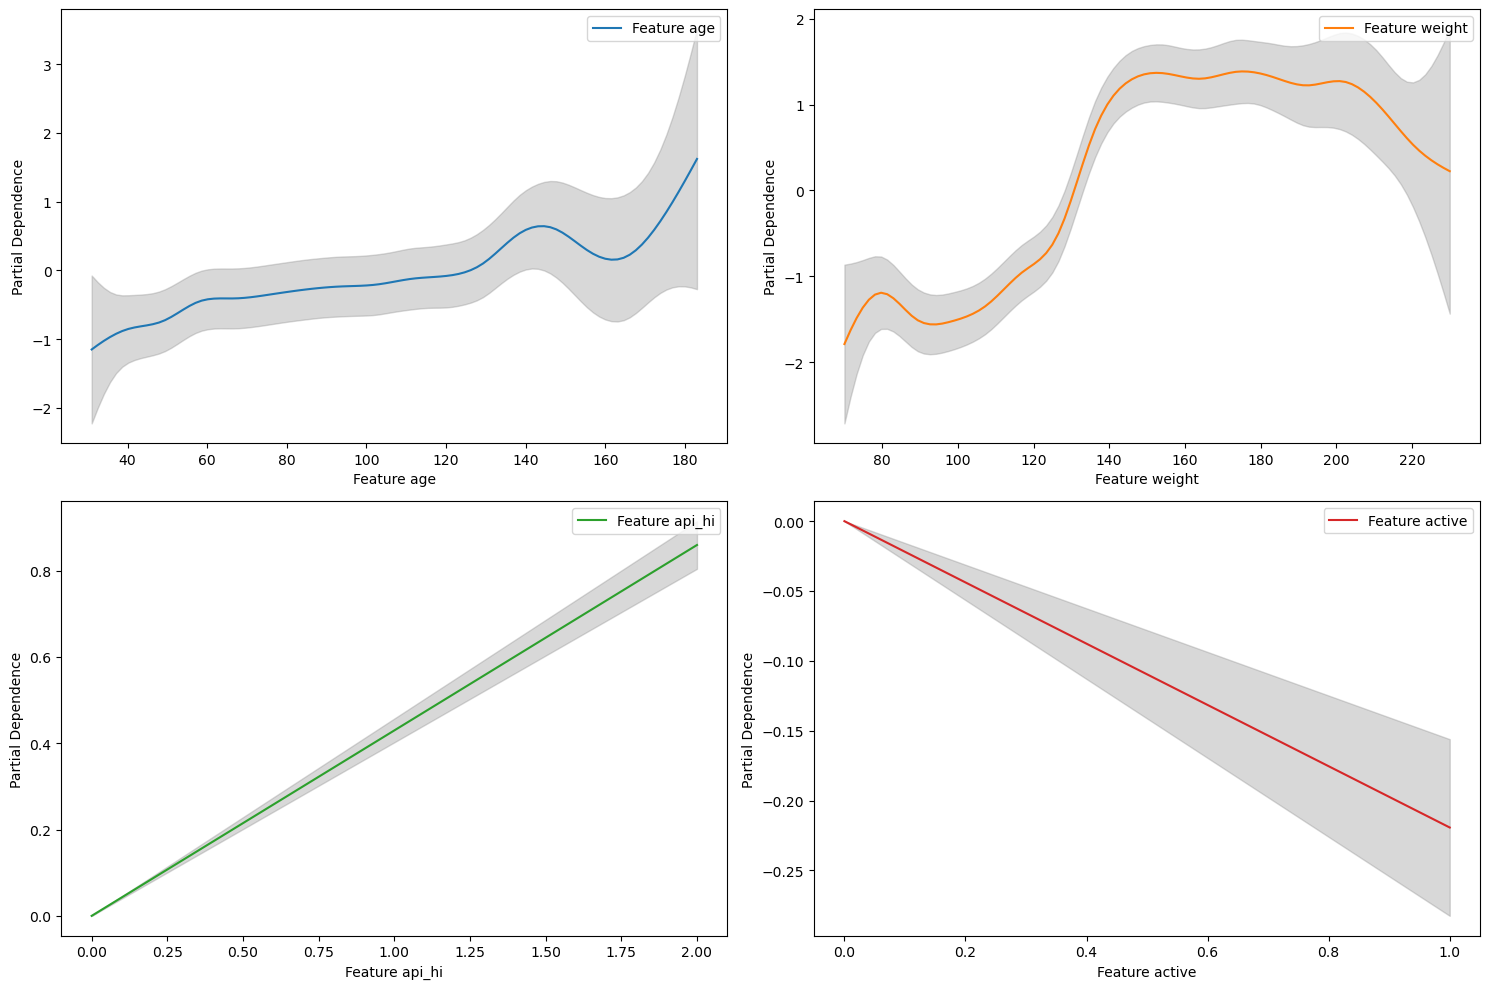

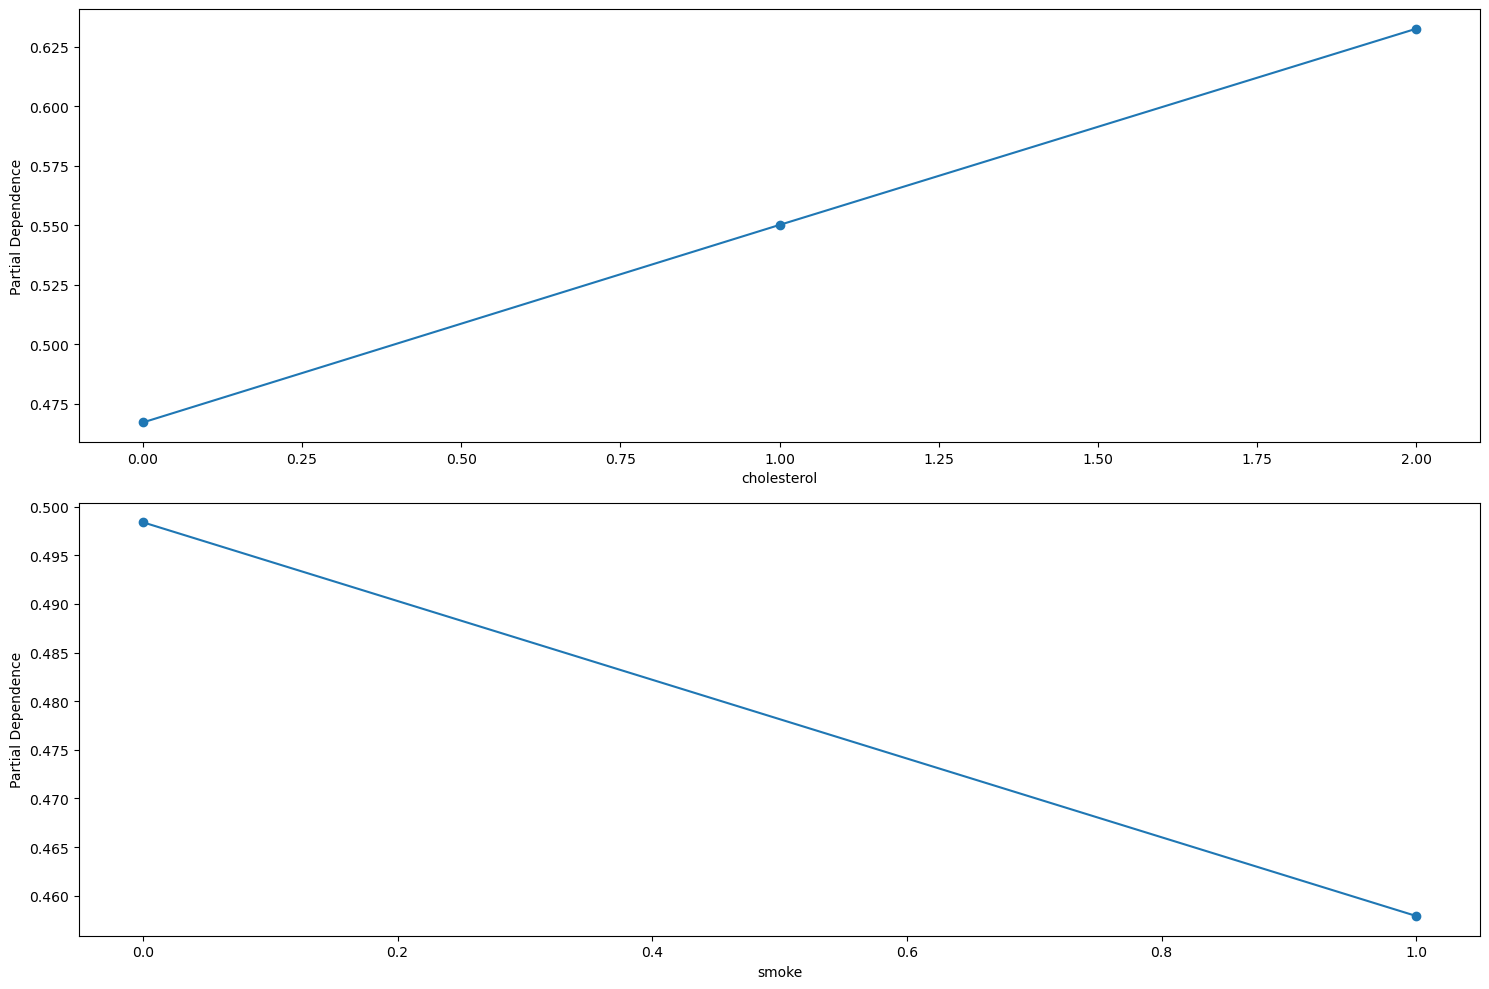

In [44]:
#GAM
#gender, cholesterol, glucose, smoking, alcohol, cardio
# Create a copy of the cleaned dataset to use for logistic regression
df_gam = df.copy()

X = df_gam.drop('cardio', axis=1)
y = df_gam['cardio']

# Define the model
# Here we're using s() for each feature assuming they're all continuous.
# Adjust the terms based on your specific features and needs.
gam = LogisticGAM(s(0, n_splines=5) + l(1) + s(2) + s(3) + s(4) + s(5) + l(6) + s(7) + l(8) + l(9) + l(10) + s(11))  # n is the number of features in X

# Fit the model
gam.fit(X, y)

# Predict probabilities and binary outcomes
y_pred_proba = gam.predict_proba(X)
y_pred = gam.predict(X)

# Convert boolean predictions to integers
y_pred_int = y_pred.astype(int)

# Convert string labels in y_true to integers
y_true_int = y.astype(int)

# Calculate AUC and accuracy
auc_score = roc_auc_score(y_true_int, y_pred_proba)
accuracy = accuracy_score(y_true_int, y_pred_int)

print(f'AUC Score: {auc_score}')
print(f'Accuracy: {accuracy}')
gam.summary()

# Plot the estimated functions for each feature
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
axes = axes.flatten()
terms=['age', 'height', 'weight', 'api_hi', 'api_lo', 'active', 'BMI']

for i, ax in enumerate(axes):
    term = gam.terms[i + 1]  # Skip the intercept term
    XX = gam.generate_X_grid(term=i + 1)
    pdep, confi = gam.partial_dependence(term=i + 1, X=XX, width=0.95)
    ax.plot(XX[:, term.feature], pdep, label=f'Feature {terms[i]}', color=f'C{i}')  # Use different colors for each feature
    ax.fill_between(XX[:, term.feature], confi[:, 0], confi[:, 1], color='gray', alpha=0.3)
    ax.set_xlabel(f'Feature {terms[i]}')
    ax.set_ylabel('Partial Dependence')
    ax.legend()

plt.tight_layout()
plt.show()

# Assuming 'gender', 'cholesterol', 'gluc', 'smoke', 'alco' are categorical variables
categorical_features = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco']

# Use LabelEncoder to convert categorical variables to integers
label_encoder = LabelEncoder()
for feature in categorical_features:
    df_gam[feature] = label_encoder.fit_transform(df_gam[feature])

# Create a grid for each unique value in the categorical feature
fig, axes = plt.subplots(len(categorical_features), figsize=(15, 10))

for i, feature in enumerate(categorical_features):
    unique_values = df_gam[feature].unique()
    unique_values.sort()

    # Initialize arrays to store partial dependence values
    pdp_values = np.zeros_like(unique_values, dtype=float)

    for j, value in enumerate(unique_values):
        temp_df = df_gam.copy()
        temp_df[feature] = value

        # Predict using the fitted GAM model
        pdp_values[j] = gam.predict_proba(temp_df.drop('cardio', axis=1)).mean()

    # Plot the partial dependence curve
    axes[i].plot(unique_values, pdp_values, marker='o')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Partial Dependence')

plt.tight_layout()
plt.show()

# Define the model w/7 variables ['gluc', 'alco', 'height', 'ap_lo', 'gender']
# Adjust the terms based on your specific features and needs.
df_gam_dropped_stuff = df_gam.drop(['gluc', 'alco', 'height', 'ap_lo', 'gender'], axis=1).copy()

X_dropped = df_gam_dropped_stuff.drop('cardio', axis=1)
y_dropped = df_gam_dropped_stuff['cardio']

reduced_gam = LogisticGAM(s(0, n_splines=5) + s(1) + s(2) + l(3) + l(4) + s(5) + s(6))  # n is the number of features in X

# Fit the model
reduced_gam.fit(X_dropped, y_dropped)

# Predict probabilities and binary outcomes
y_pred_proba_dropped = reduced_gam.predict_proba(X_dropped)
y_pred_dropped = reduced_gam.predict(X_dropped)

# Convert boolean predictions to integers
y_pred_int_dropped = y_pred_dropped.astype(int)

# Convert string labels in y_true to integers
y_true_int_dropped = y_dropped.astype(int)

# Calculate AUC and accuracy
auc_score_dropped = roc_auc_score(y_true_int_dropped, y_pred_proba_dropped)
accuracy_dropped = accuracy_score(y_true_int_dropped, y_pred_int_dropped)

print(f'AUC Score: {auc_score_dropped}')
print(f'Accuracy: {accuracy_dropped}')
reduced_gam.summary()

# Plot the estimated functions for each feature
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
terms_dropped=['age', 'weight', 'api_hi', 'active', 'BMI']

# Ensure the number of terms matches the length of the 'terms_dropped' list
num_terms_dropped = min(len(terms_dropped), len(reduced_gam.terms) - 1)  # Skip the intercept term
terms_to_plot_dropped = reduced_gam.terms[1:num_terms_dropped + 1]  # Select the relevant terms

for i, ax in enumerate(axes):
    term = terms_to_plot_dropped[i]
    XX = reduced_gam.generate_X_grid(term=i + 1)
    pdep, confi = reduced_gam.partial_dependence(term=i + 1, X=XX, width=0.95)
    ax.plot(XX[:, term.feature], pdep, label=f'Feature {terms_dropped[i]}', color=f'C{i}')  # Use different colors for each feature
    ax.fill_between(XX[:, term.feature], confi[:, 0], confi[:, 1], color='gray', alpha=0.3)
    ax.set_xlabel(f'Feature {terms_dropped[i]}')
    ax.set_ylabel('Partial Dependence')
    ax.legend()

plt.tight_layout()
plt.show()

# Assuming 'cholesterol', 'smoke' are categorical variables
categorical_features_dropped = ['cholesterol', 'smoke']

# Use LabelEncoder to convert categorical variables to integers
label_encoder = LabelEncoder()
for feature in categorical_features_dropped:
    df_gam[feature] = label_encoder.fit_transform(df_gam_dropped_stuff[feature])

# Create a grid for each unique value in the categorical feature
fig, axes = plt.subplots(len(categorical_features_dropped), figsize=(15, 10))

for i, feature in enumerate(categorical_features_dropped):
    unique_values = df_gam_dropped_stuff[feature].unique()
    unique_values.sort()

    # Initialize arrays to store partial dependence values
    pdp_values = np.zeros_like(unique_values, dtype=float)

    for j, value in enumerate(unique_values):
        temp_df = df_gam_dropped_stuff.copy()
        temp_df[feature] = value

        # Predict using the fitted GAM model
        pdp_values[j] = reduced_gam.predict_proba(temp_df.drop('cardio', axis=1)).mean()

    # Plot the partial dependence curve
    axes[i].plot(unique_values, pdp_values, marker='o')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Partial Dependence')

plt.tight_layout()
plt.show()